In [1]:
from dlc_practical_prologue import generate_pair_sets

nSamples = 1000
data = generate_pair_sets(nSamples)
var_names = ["train_input", "train_target", "train_classes", "test_input", "test_target", "test_classes"]
train_input, train_target, train_classes, test_input, test_target, test_classes = data
stringWidth = 20
for i, el in enumerate(list(map(lambda x: (x.shape, x.dtype), data))):
    print('{:s}  {:s}  {:s}'.format(
        var_names[i].ljust(stringWidth),
        ' x '.join(list(map(lambda x: str(x), list(el[0])))).center(stringWidth), 
        'dtype'.ljust(stringWidth)))

train_input            1000 x 2 x 14 x 14   dtype               
train_target                  1000          dtype               
train_classes               1000 x 2        dtype               
test_input             1000 x 2 x 14 x 14   dtype               
test_target                   1000          dtype               
test_classes                1000 x 2        dtype               


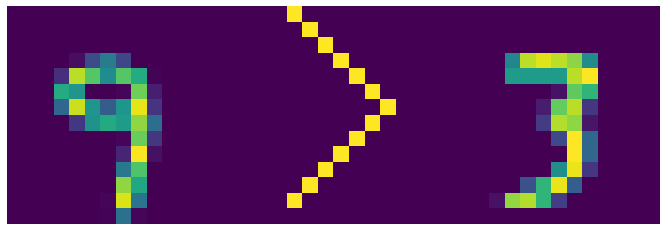

In [2]:
from utils import show_pair

show_pair(train_input, train_target, 0)

## Without using the information from the classes

In [15]:
from utils import Net1, train_model 
import torch
import torch.nn as nn

model = Net1(50)
criterion = nn.BCEWithLogitsLoss()
eta = 1e-3
mini_batch_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr = eta)
nb_epochs = 10


        
train_model(model, train_input, train_target.float(), test_input, test_target, nb_epochs, mini_batch_size, optimizer, criterion)

Epoch 0: loss 8.620 / train accuracy 72.2%, test accuracy 72.7
Epoch 1: loss 5.137 / train accuracy 79.5%, test accuracy 76.4
Epoch 2: loss 4.143 / train accuracy 83.3%, test accuracy 79.8
Epoch 3: loss 3.645 / train accuracy 85.8%, test accuracy 80.7
Epoch 4: loss 3.274 / train accuracy 88.1%, test accuracy 82.5
Epoch 5: loss 2.653 / train accuracy 91.5%, test accuracy 83.5
Epoch 6: loss 2.161 / train accuracy 92.5%, test accuracy 83.7
Epoch 7: loss 1.780 / train accuracy 95.7%, test accuracy 83.4
Epoch 8: loss 1.502 / train accuracy 95.3%, test accuracy 83.1
Epoch 9: loss 1.400 / train accuracy 97.1%, test accuracy 83.6


In [10]:
nParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('The model has {:d} trainable parameters'.format(nParams))

The model has 74489 trainable parameters


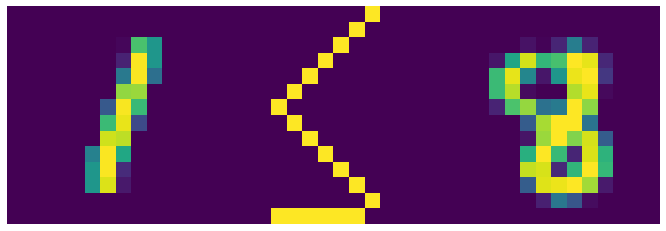

In [11]:
predictions = model(test_input)
show_pair(test_input, predictions, 10)

## With class information during training

In [14]:
from utils import Net2, train_model_double_objective

model = Net2(50)
criterion = nn.BCEWithLogitsLoss()
criterion2 = nn.CrossEntropyLoss()
eta = 1e-3
mini_batch_size = 10
optimizer = torch.optim.Adam(model.parameters(), lr = eta)
nb_epochs = 10


        
train_model_double_objective(model, train_input, train_target.float(), 
                             train_classes, test_input, test_target, 
                             test_classes, nb_epochs, mini_batch_size, optimizer, 
                             criterion, criterion2, beta = 1)

Epoch 0: loss 429.615 / train accuracy 76.2%, test accuracy 74.4
Epoch 1: loss 189.136 / train accuracy 78.4%, test accuracy 77.9
Epoch 2: loss 126.880 / train accuracy 84.3%, test accuracy 83.3
Epoch 3: loss 91.325 / train accuracy 84.3%, test accuracy 83.1
Epoch 4: loss 77.909 / train accuracy 87.1%, test accuracy 84.7
Epoch 5: loss 66.689 / train accuracy 88.1%, test accuracy 86.3
Epoch 6: loss 66.021 / train accuracy 89.3%, test accuracy 86.2
Epoch 7: loss 52.670 / train accuracy 91.1%, test accuracy 87.0
Epoch 8: loss 48.462 / train accuracy 92.1%, test accuracy 88.4
Epoch 9: loss 47.032 / train accuracy 90.6%, test accuracy 88.9
